# Example for an excited state calculation

Short example of how to form the objectives for the ''hangman's'' approach to excited states.  
Here the states are sequentially computed and are kept orhogonal towards previous states by projection.  

The method was for example applied in:
https://pubs.acs.org/doi/pdf/10.1021/acs.jctc.8b01004

See also our overview article [arxiv.org/abs/2011.03057](http://arxiv.org/abs/2011.03057) and our article on optimized fermionic gradients [arxiv.org/abs/2011.05938](https://arxiv.org/abs/2011.05938) for more information.

The overlap objective is formed from the quantum circuits of the optimized lower lying states $U_i$ and the current parametrized circuit $U(a)$ like this:

$$
S_i^2(a) = \|\langle \Psi_i \rvert \Psi(a) \rangle\|^2 = \|\langle 0 \rvert U_i^\dagger U(a) \lvert 0 \rangle\|^2 = 
 \langle 0 \rvert U^\dagger(a) U_i  P_0 U_i^\dagger U(a) \lvert\rangle = \langle P_0 \rangle_{U_i^\dagger U(a)} $$
 
where $P_0 = \lvert 0..0 \rangle \langle 0..0 \rvert = \otimes^n Q_+ =  \frac{1}{2^n} \otimes^n (1 + Z)$.

Bound states can then be kept orthogonal by projecting lower lying states out which is equivalent as minimizing the objective:

$$
 L = \langle H \rangle_{U(a)} - E_i S_i^2(a)
$$


We will use an active space Beryllium Hydride molecule with two orbitals because the circuit template is easy to construct for this example and it executes fast.

<img src="data/ex_solver_cartoon-1.png" width="200" height="200" />

In [1]:
geomstring="be 0.0 0.0 0.0\nh 0.0 0.0 {R}\nh 0.0 0.0 -{R}"

In [2]:
import tequila as tq

fci_gs = []
fci_es = []
energies_gs = []
energies_es = []
P0 = tq.paulis.Projector("|00>")
for R in [0.7 + 0.1*i for i in range(25)]:
    print("Optimizing point R={:2.1f}".format(R))
    active = {"b1u": [0], "b2u": [0]}
    mol = tq.chemistry.Molecule(geometry=geomstring.format(R=R), basis_set="6-31g", active_orbitals=active)
    H = mol.make_hamiltonian()
    results = []
    for i in range(2):
        U = tq.gates.Ry((i, "a"), 0)
        U += tq.gates.CNOT(0, 1) + tq.gates.CNOT(0, 2)
        U += tq.gates.CNOT(1, 3) + tq.gates.X([2, 3])
        E = tq.ExpectationValue(U, H)
        active_vars = E.extract_variables()
        angles = {angle: 0.0 for angle in active_vars}
        for data, U2 in results:
            S2 = tq.ExpectationValue(H=P0, U=U + U2.dagger())
            E -= data.energy * S2
            angles = {**angles, **data.angles}
        print("Starting to optimize state ", i)
        result = tq.optimizer_scipy.minimize(E, method="bfgs", variables=active_vars, initial_values=angles, silent=True)
        print("finished with energy {:2.8f}".format(result.energy))
        results.append((result, U))
    energies_gs.append(results[0][0].energy)
    energies_es.append(results[1][0].energy)

Optimizing point R=0.7
Starting to optimize state  0
finished with energy -15.08170491
Starting to optimize state  1
finished with energy -14.15900421
Optimizing point R=0.8
Starting to optimize state  0
finished with energy -15.36599843
Starting to optimize state  1
finished with energy -14.48743629
Optimizing point R=0.9
Starting to optimize state  0
finished with energy -15.54369428
Starting to optimize state  1
finished with energy -14.70864582
Optimizing point R=1.0
Starting to optimize state  0
finished with energy -15.65189560
Starting to optimize state  1
finished with energy -14.85821915
Optimizing point R=1.1
Starting to optimize state  0
finished with energy -15.71447523
Starting to optimize state  1
finished with energy -14.95919037
Optimizing point R=1.2
Starting to optimize state  0
finished with energy -15.74678206
Starting to optimize state  1
finished with energy -15.02665710
Optimizing point R=1.3
Starting to optimize state  0
finished with energy -15.75882309
Startin

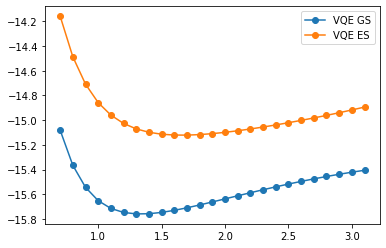

In [3]:
import matplotlib.pyplot as plt
R =  [0.7 + 0.1*i for i in range(len(energies_gs))]
plt.figure()
plt.plot(R, energies_gs, marker="o", label="VQE GS")
plt.plot(R, energies_es, marker="o", label="VQE ES")
plt.legend()
plt.show()

Here is the same calculation using the [UpCCGSD](https://pubs.acs.org/doi/10.1021/acs.jctc.8b01004) construction for the untitary circuit with \textsc{tequila}s [optimized scheme for fermionic gradients](https://arxiv.org/abs/2011.05938).  
In addition we changed to numerical gradients in order to not spend to much time on computing in this notebook.  
Note that in this super restricted active space we do not need to change the reference (allthough we could speed up convergence by switching from the Hartree-Fock reference (in jordan_wigner encoding: $\lvert 1100 \rangle)$ to the double excited configuration ($\lvert 0011 \rangle$). 

Try it out by setting `include_reference=False` in `make_upccgsd` and adding the gates to prepare the reference manually.

In [4]:
import tequila as tq

fci_gs = []
fci_es = []
energies_gs = []
energies_es = []
P0 = tq.paulis.Projector("|00>")
for R in [0.7 + 0.1*i for i in range(25)]:
    print("Optimizing point R={:2.1f}".format(R))
    active = {"b1u": [0], "b2u": [0]}
    mol = tq.chemistry.Molecule(geometry=geomstring.format(R=R), basis_set="6-31g", active_orbitals=active)
    H = mol.make_hamiltonian()
    results = []
    for i in range(2):
        # labeling ensures that tequila can distinguish the variables
        # singles can break the symmetry here falling into different states than the two above
        # (i.e. the open-shell singly excited manifold: in jordan_wigner those states are build from
        #  |1001> and |0110>)
        U = mol.make_upccgsd_ansatz(label=i, include_singles=False) 
        E = tq.ExpectationValue(U, H)
        active_vars = E.extract_variables()
        angles = {angle: 0.0 for angle in active_vars}
        for data, U2 in results:
            S2 = tq.ExpectationValue(H=P0, U=U + U2.dagger())
            E -= data.energy * S2
            angles = {**angles, **data.angles}
        print("Starting to optimize state ", i)
        result = tq.optimizer_scipy.minimize(E, silent=True, method="bfgs", method_options={"finite_diff_rel_step":1.e-4, "eps":1.e-4}, variables=active_vars, initial_values=angles)
        print("finished with energy {:2.8f}".format(result.energy))
        results.append((result, U))
    energies_gs.append(results[0][0].energy)
    energies_es.append(results[1][0].energy)

Optimizing point R=0.7
Starting to optimize state  0
finished with energy -15.08170497
Starting to optimize state  1
finished with energy -14.15900421
Optimizing point R=0.8
Starting to optimize state  0
finished with energy -15.36599853
Starting to optimize state  1
finished with energy -14.48743439
Optimizing point R=0.9
Starting to optimize state  0
finished with energy -15.54369454
Starting to optimize state  1
finished with energy -14.70864582
Optimizing point R=1.0
Starting to optimize state  0
finished with energy -15.65189604
Starting to optimize state  1
finished with energy -14.85821915
Optimizing point R=1.1
Starting to optimize state  0
finished with energy -15.71447564
Starting to optimize state  1
finished with energy -14.95918560
Optimizing point R=1.2
Starting to optimize state  0
finished with energy -15.74678225
Starting to optimize state  1
finished with energy -15.02665520
Optimizing point R=1.3
Starting to optimize state  0
finished with energy -15.75882312
Startin

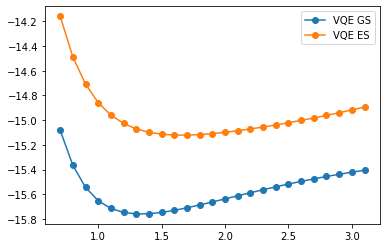

In [5]:
import matplotlib.pyplot as plt
R =  [0.7 + 0.1*i for i in range(len(energies_gs))]
plt.figure()
plt.plot(R, energies_gs, marker="o", label="VQE GS")
plt.plot(R, energies_es, marker="o", label="VQE ES")
plt.legend()
plt.show()